**DO NOT EDIT THIS FILE WITHIN THE /TSDS FOLDER - YOU RISK OVERWRITING YOUR WORK THE NEXT TIME YOU PULL FROM THE GITHUB REPOSITORY**

# Group members:
## Sina Smid, Edith Zink, Zeyu Zhao, Helge Zille





# Assignment 1


### Practical info
* Handin in absalon. The deadline is the 5th of march (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 1 (ML recap)
The following questions are drawn from exercise set 1. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer. 

In [2]:
# Note: there are three .zip files with letter = a,b,c. 
# To ensure the files download in reasonable time we 
# only work with the first of the three. If you have time
# you can modify this cell to download all three. 

import os
import requests

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler        # scales variables to be mean=0,sd=1
from sklearn.linear_model import LogisticRegression     # regression model
from sklearn.pipeline import Pipeline                   # For building our model pipeline
from sklearn.model_selection import GridSearchCV



filenames = []
base_url = 'https://resources.lendingclub.com/'

letter = 'a'
filename = f'LoanStats3{letter}.csv.zip'
url = base_url+filename

if not os.path.exists(filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
filenames.append(filename)

# Read in csv files, store them
dfs = [pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in filenames]

# concatenate the dataframes (as standard there is only 1)
df = pd.concat(dfs)\
        .dropna(subset=['loan_amnt'])\
        .dropna(axis=1, how='all')


# Identify loans of interest
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])].copy()

# Clean up variables 
df['charged_off'] = (df.loan_status=='Charged Off').astype(int)
df['int_rate_f'] = df.int_rate.str[:-1].astype(float)
df['emp_length_f'] = df.emp_length\
                        .str.split(' ')\
                        .str[0].str[:2]\
                        .str.replace('<','0')\
                        .astype(float)

# label and features
y_var = 'charged_off'
X_vars = ['term', 'int_rate_f', 'grade', 'home_ownership', 'emp_length_f',
          'annual_inc', 'verification_status', 'dti']

# Create dummies
data = pd.get_dummies(df[X_vars+[y_var]], drop_first=True)\
        .dropna()\
        .reset_index(drop=True)\
        .astype(np.float64)\
        .loc[:2000]\
        .copy()


sss = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=3)

# These are the row indices of the stratified split
data_splits = list(sss.split(data[y_var], data[y_var]))

# Separate data in y,X
y = data[y_var]
X_vars_b = data.columns!=y_var
X = data.loc[:,X_vars_b]

train_idx, test_idx = data_splits[0]

y_train = y.loc[train_idx]
X_train = X.loc[train_idx]

y_test = y.loc[test_idx]
X_test = X.loc[test_idx]


# Fit vanilla linear model
lr = Pipeline([('scale', StandardScaler()),
               ('clf', LogisticRegression(class_weight='balanced',C=10**10, solver = 'liblinear'))])


lr.fit(X_train, y_train)


# Fit linear model with CV
lr_cv = GridSearchCV(estimator=lr,
                     param_grid={'clf__C':np.logspace(-4,4,5)},
                     n_jobs=-1,
                     cv=3)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10000000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

> **Ex. 1.1.8:** Apply nested resampling to compute a distribution of test scores with and without optimization. You should use `data_splits` which we defined initially and input all the data.
>
>> *Hint:* You can implement this using your code from Ex. 1.1.6 and combine it with `cross_val_score`. Note that `cv` input should use `data_splits`. See Raschka pp. 188-189 for inspiration. 

In [3]:
from sklearn.model_selection import cross_val_score

cvs=cross_val_score(lr,X,y,cv=data_splits,scoring='f1')

cvs_opt=cross_val_score(lr_cv,X,y,cv=data_splits,scoring='f1')

print('CV accuracy scores: %s'% cvs)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(cvs), np.std(cvs)))

print('CV accuracy scores optimized: %s'% cvs_opt)
print('CV accuracy optimized: %.3f +/- %.3f' % (np.mean(cvs_opt), np.std(cvs_opt)))

CV accuracy scores: [0.33727811 0.40233236 0.32       0.36612022 0.35164835 0.3452381
 0.3559322  0.37317784 0.38692098 0.37082067]
CV accuracy: 0.361 +/- 0.023
CV accuracy scores optimized: [0.3373494  0.40121581 0.3003663  0.38616715 0.39889197 0.33438486
 0.34857143 0.35555556 0.38068182 0.3322884 ]
CV accuracy optimized: 0.358 +/- 0.031


In [5]:
#### EDITHS SOLUTION:
from sklearn.model_selection import cross_val_score

nested_cv_score_nonopt = cross_val_score(estimator= lr, 
                                         X=X, y=y, 
                                         cv=data_splits,
                                         scoring='f1',
                                         n_jobs=-1)

nested_cv_score_opt = cross_val_score(estimator= lr_cv, 
                                      X=X, y=y,
                                      cv=data_splits, 
                                      scoring='f1',
                                      n_jobs=-1)

print(nested_cv_score_nonopt)
print(nested_cv_score_opt)

[0.33727811 0.40233236 0.32       0.36612022 0.35164835 0.3452381
 0.3559322  0.37317784 0.38692098 0.37082067]
[0.3373494  0.40121581 0.3003663  0.38616715 0.39889197 0.33438486
 0.34857143 0.35555556 0.38068182 0.3322884 ]


>  **Ex. 1.1.11** Estimate a classification tree on the training data (with default hyperparameters). Evalate both on training and test data by computing the *area under the curve*.
>
>> *Hint:* You can check out code for Ex. 1.1.10 for inspiration. You may also want to look up `roc_auc_score`.

In [6]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier

from sklearn import metrics #Import scikit-learn metrics module for area under the curve calculation

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for train and test dataset
y_score_train = clf.predict_proba(X_train)
y_score_test = clf.predict_proba(X_test)

print("AUC (training set):",metrics.roc_auc_score(y_train, y_score_train[:,1]))
print("AUC (testing set):",metrics.roc_auc_score(y_test, y_score_test[:,1]))

AUC (training set): 1.0
AUC (testing set): 0.5008135003216164


>  **Ex. 1.1.13** Is Random Forest classification different from the procedure of aggregating tree predictions above? If so, explain how.

In [ ]:
# [Answer to ex.1.1.13 here]

Yes, they are different because Random Forests also do feature bagging (= bootstrap which features to use).
The idea behind Random Forests is to average multiple DCTs to build a more robust model that has better generalization performance. 
A Random Forest model runs the following steps:
1. Draw a random bootstrap sample.
2. Grow decision tree from the bootstrap sample
  1. randomly select a fixed number of features without replacement
  2. split the node using the feature that provides best split
3. Repeat 1. and 2.
4. Aggregate the results of each tree via majority vote.

Obviously, Random Forest classification is different from the aggregating procedure in the exercise.

<br>
<br>
<br>
<br>

# Questions from exercise set 2 (ANN 1)
The following questions are drawn from exercise set 2. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer.

In [7]:
import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d


# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q: Print these out, explain their contents. You can instantiate a network by
        # doing `net = Network([2, 3, 1])`, and then printing `net.biases`.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            
            # Q: What happens here? Why do we shuffle the training data? Explain the
            # contents of `mini_batches`.
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Q: These two vectors correspond to -∇C(W) (and -∇C(b))
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Q: But what happens here? Explain, in particular, how we update `nabla_b` and `nabla_w`
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # Q: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them
        # to update the weights and biases
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y
    
    
# Load in the MNIST data used for ex. 2.2.x    
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

plt.imshow(training_data[0][0].reshape(28, 28))
plt.show()

<Figure size 640x480 with 1 Axes>

**Ex. 2.1.2** Using [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the hard-to-seperate circles, create the minimal neural network that seperates the clusters. Again, report your answer with a link.

https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=3&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false

**Ex. 2.2.4**: Now, fit a model with a suiting architecture (i.e. `sizes`) to `training_data`, and report your accuracy on the `validation_data`.

In [8]:
# [Answer to ex. 2.2.4]

net = Network([784, 30, 10])
net.SGD(training_data, 30, 10, 3.0, test_data=validation_data)

net.evaluate(validation_data)

Epoch 0: 9105 / 10000
Epoch 1: 9295 / 10000
Epoch 2: 9346 / 10000
Epoch 3: 9388 / 10000
Epoch 4: 9413 / 10000
Epoch 5: 9447 / 10000
Epoch 6: 9456 / 10000
Epoch 7: 9473 / 10000
Epoch 8: 9481 / 10000
Epoch 9: 9480 / 10000
Epoch 10: 9492 / 10000
Epoch 11: 9488 / 10000
Epoch 12: 9511 / 10000
Epoch 13: 9506 / 10000
Epoch 14: 9512 / 10000
Epoch 15: 9521 / 10000
Epoch 16: 9498 / 10000
Epoch 17: 9513 / 10000
Epoch 18: 9530 / 10000
Epoch 19: 9533 / 10000
Epoch 20: 9525 / 10000
Epoch 21: 9537 / 10000
Epoch 22: 9539 / 10000
Epoch 23: 9551 / 10000
Epoch 24: 9535 / 10000
Epoch 25: 9532 / 10000
Epoch 26: 9510 / 10000
Epoch 27: 9537 / 10000
Epoch 28: 9539 / 10000
Epoch 29: 9550 / 10000


9550

**Ex. 2.2.5**: Assuming you could get a "pretty" high accuracy in Ex. 2.2.4, Visualize 10 examples that get misclassified (remember to write what the correct label is). comment on what you see.

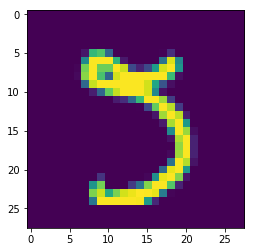

We predict this to be 3


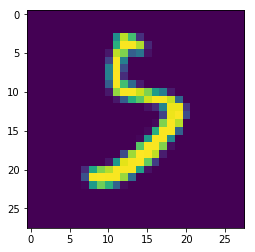

We predict this to be 2


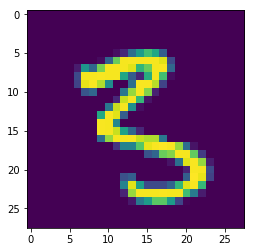

We predict this to be 5


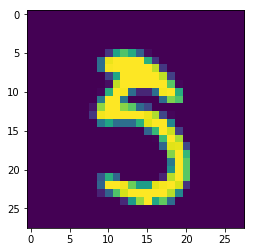

We predict this to be 3


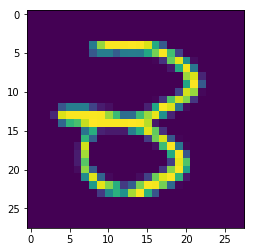

We predict this to be 8


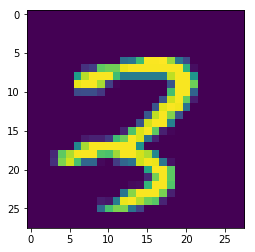

We predict this to be 2


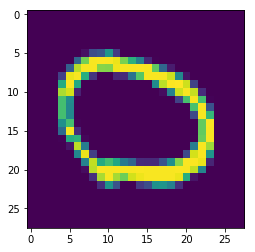

We predict this to be 2


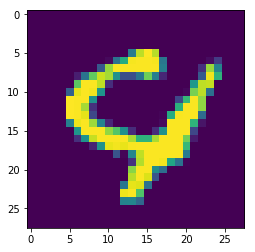

We predict this to be 9


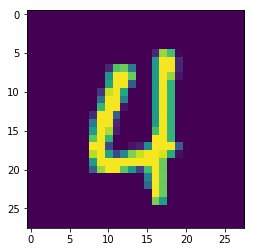

We predict this to be 0


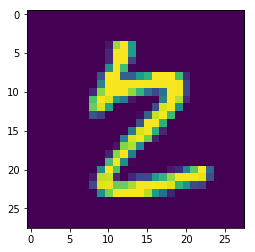

We predict this to be 8


In [9]:
# [Answer to ex. 2.2.5]

y_train = [training_data[i][1] for i in range(len(training_data))]
X_train = [training_data[i][0] for i in range(len(training_data))]

y_validation = [training_data[i][1] for i in range(len(validation_data))]
X_validation = [training_data[i][0] for i in range(len(validation_data))]

y_pred = [net.feedforward(x) for x in X_validation]

ind_pred =[np.argmax(y_pred[i]) for i in range(len(y_pred))]
ind_true =[np.argmax(y_validation[i]) for i in range(len(y_validation))]

li=[]

for i in range(len(y_validation)):
    if ind_pred[i]!=ind_true[i]:
        li=li+[i]
        
for i in range(10):
    plt.imshow(training_data[li[i]][0].reshape(28,28))
    plt.show()
    print('We predict this to be ' + str(ind_pred[li[i]]))

<br>
<br>
<br>
<br>

# Questions from exercise set 3 (ANN 2)
The following questions are drawn from exercise set 3. 

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

**Ex. 3.1.2**: Knowing about backpropagation, we actually have everything we need here to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*

In [ ]:
# [Answer to ex. 3.1.2]

We used the following general formula to calculate the gradient for weight $w_{jk}^{l}$ to the hidden layer, hence, the weight for the connection from the $k_{th}$ neuron in the input layer to the $j_{th}$ neuron in the hidden layer $l$. In the formula $L$ indicates the output layer:
$$ \frac{\partial C}{\partial w_{jk}^{l}} = \frac{\partial C}{\partial a^{L}} \frac{\partial a^{L}}{\partial a^{l}_{j}} \frac{\partial a^{l}_{j}}{\partial w^{l}_{jk}} $$

where
$$ 
\begin{aligned}
\frac{\partial C}{\partial a^{L}} &= 2*(a^{L} - 1) \\
\frac{\partial a^{L}}{\partial a^{l}_{j}} &= w_{j}^{L} \sigma^{'}(z^{L}) \\
\frac{\partial a^{l}_{j}}{\partial w^{l}_{jk}} &= x_{k} \sigma^{'}(z^{l}_{j}) 
\end{aligned}
$$

The gradient for the weights from hidden to output layer are computed as follows:
$$ \frac{\partial C}{\partial w_{j}^{L}} = \frac{\partial C}{\partial a^{L}} \frac{\partial a^{L}}{\partial w^{L}_{j}}$$
where $$\frac{\partial a^{L}}{\partial w^{L}_{j}} = a^{l}_{j} \sigma^{'}(z^{L}) $$

In [2]:
import math

def sigmoid(x):
  return 1 / (1 + math.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))

z1_1 = 4*0.5 + 2*1 + 1
z1_2 = 4*2 + 2*10 - 1
z1_3= 4*(-5) + 2*0.3 + 2

a1_1 = sigmoid(z1_1)
a1_2 = sigmoid(z1_2)
a1_3 = sigmoid(z1_3)

zL = 12*a1_1 - 8*a1_2 + 0.2*a1_3 - 3
aL = sigmoid(zL)

### The gradients for all the weights are:
cost_derivative = 2*(aL - 1)

w1_11 = cost_derivative * 12 * sigmoid_derivative(zL) * 4 * sigmoid_derivative(z1_1)
w1_21 = cost_derivative * (-8) * sigmoid_derivative(zL) * 4 * sigmoid_derivative(z1_2)
w1_31 = cost_derivative * 0.2 * sigmoid_derivative(zL) * 4 * sigmoid_derivative(z1_3)
w1_12 = cost_derivative * 12 * sigmoid_derivative(zL) * 2 * sigmoid_derivative(z1_1)
w1_22 = cost_derivative * (-8) * sigmoid_derivative(zL) * 2 * sigmoid_derivative(z1_2)
w1_32 = cost_derivative * 0.2 * sigmoid_derivative(zL) * 2 * sigmoid_derivative(z1_3)

wL_1 = cost_derivative * a1_1 * sigmoid_derivative(zL)
wL_2 = cost_derivative * a1_2 * sigmoid_derivative(zL)
wL_3 = cost_derivative * a1_3 * sigmoid_derivative(zL)

print("Gradients for the weights to the hidden layer, first input", round(w1_11,5), "(first neuron),", 
                      round(w1_21,5), "(second neuron),", round(w1_31,5), "(third neuron)")
print("Gradients for the weights to the hidden layer, second input", round(w1_12,5), "(first neuron),", 
                      round(w1_22,5), "(second neuron),", round(w1_32,5), "(third neuron)")
print("Gradients for the weights to the output layer", round(wL_1,5), "(first neuron),", 
                      round(wL_2,5), "(second neuron),", round(wL_3,5), "(third neuron)")

Gradients for the weights to the hidden layer, first input -0.0371 (first neuron), 0.0 (second neuron), -0.0 (third neuron)
Gradients for the weights to the hidden layer, second input -0.0185 (first neuron), 0.0 (second neuron), -0.0 (third neuron)
Gradients for the weights to the output layer -0.1154 (first neuron), -0.11617 (second neuron), -0.0 (third neuron)


![title](Inked2_3_1_net_compgraph_backward_SJS.jpg)

In [1]:
# SINA SOLUTION: Backpropagation
# Sigmoid function
from math import exp, expm1
def sig(x):
    x1=1/(1+exp(-x))
    return(x1)
# Derivative Sigmoid function
from math import exp, expm1
def sig_derivative(x):
    x1=sig(x)*(1-sig(x))
    return(x1)

#Backpropagation - Level 1
b1=2*(0.71497807983374-1)
print(b1)

#Backpropagation - Level 2
b2=sig_derivative(0.919)*-0.57
print(b2)

#Backpropagation - Level 3 - where it splits up
b3=b2*0.2
print(b3)

b4=b2*-8
print(b4)

b5=b2*12
print(b5)

#Backpropagation - Level 4
b6=sig_derivative(0.993)*b5
print(b6)

b7=sig_derivative(0.999)*b4
print(b7)

b8=sig_derivative(0)*b3
print(b8)

#Backpropagation - Level 5
b9_1=b6*0.5
print(b9_1)

b9_2=b6*1
print(b9_2)

b10_1=b7*2
print(b10_1)

b10_2=b7*10
print(b10_2)

b11_1=b8*-5
print(b11_1)

b11_2=b8*-0.3
print(b11_2)

-0.5700438403325201
-0.11619136654182528
-0.02323827330836506
0.9295309323346023
-1.3942963985019035
-0.27502087225105226
0.18284131226372166
-0.005809568327091265
-0.13751043612552613
-0.27502087225105226
0.3656826245274433
1.8284131226372167
0.029047841635456324
0.0017428704981273795


In [9]:
# Presentation - Derivative cost function: Step 1
print(2*(0.95-1))

# Assignment
2*(0.71497807983374-1)

-0.10000000000000009


-0.5700438403325201

In [10]:
# Presentation - Derivative sigmoid: Step 2
print(sig_derivative(3)*-0.1)

# Assignment
sig_derivative(0.92)*-0.57


-0.0045176659730912


-0.11614142888214005

<br>
<br>
<br>
<br>

# Questions from exercise set 4 (ANN 3)
The following questions are drawn from exercise set 4. Once again we provide you the code required to answer the question.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import mnist_loader
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

# Download the data (thanks MIT)
response = requests.get("http://shakespeare.mit.edu/hamlet/full.html")
hamlet = BeautifulSoup(response.content, "html.parser").getText()

# Convert text to character-level one-hot encoding
hamlet_one_hot = pd.get_dummies(pd.Series(list(hamlet)))
character_vec = hamlet_one_hot.columns
x = torch.from_numpy(hamlet_one_hot.values.astype(np.float32))


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Neural network layers. Rather than giving the input as a one-hot
        # vector, we represent it as a point in a high-dimensional space (i.e.
        # "an embedding"). This tends to work better.
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        signal = self.encoder(input_).view(1, 1, -1)  # Embed input character
        output, hidden = self.rnn(signal, hidden)     # Get output and hidden vector(s)
        prediction = self.decoder(output.view(1, -1))     # Decode to "prediction" vector
        
        return prediction, hidden

    def init_hidden(self):
        return (
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        )
    
epochs = 10000
seq_len = 200
learning_rate = 1e-2
n_layers = 2

model = RNN(len(character_vec), 100, len(character_vec), n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# We're collecting the losses so we can plot how they (hopefully) decrease over time
all_losses = []
fraction_correct = []
for t in tqdm(range(epochs)):
    
    # Initiate a hidden vector for 
    hidden = model.init_hidden()
    
    # Pick a random input and output sequence. Here we are only taking one sequence
    # per epoch, but normally people take a batch of sequences. Check https://github
    # .com/spro/char-rnn.pytorch for an example on how to do that
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]      # torch.max(...)[1] gets the character in terms of its index, so
    target = torch.max(x[i+1:i+1+seq_len], 1)[1]  # input_ will be something like torch.tensor([2, 1, 4, 0, ... 1])
    
    # Backprop through time. Here we are just summing the losses from each timestep
    # and do backpropagation on the variable that holds the sum. PyTorch allows for that
    optimizer.zero_grad()
    loss = 0
    correct = 0
    for j in range(input_.size(0)):
        output, hidden = model(input_[j], hidden)
        loss += loss_fn(output.view(1, -1), target[j].view(1, ))
        correct += int(torch.max(output.view(1, -1), 1)[1][0] == target[j])
    
    # SGD step
    loss.backward()
    optimizer.step()
    
    # Collect loss value for plot
    all_losses.append(float(loss))
    fraction_correct.append(correct / input_.size(0))
        
    # Progress
    if t % 10 == 0:
        print(t, "| loss:", float(loss), "| fraction correct:", fraction_correct[-1])
    
    
plt.plot(all_losses)
plt.show()

0 | loss: 832.710205078125 | fraction correct: 0.025
10 | loss: 676.6260375976562 | fraction correct: 0.16
20 | loss: 675.1060791015625 | fraction correct: 0.155
30 | loss: 581.9262084960938 | fraction correct: 0.245
40 | loss: 571.442138671875 | fraction correct: 0.23
50 | loss: 538.3378295898438 | fraction correct: 0.225
60 | loss: 516.1564331054688 | fraction correct: 0.28
70 | loss: 482.0628662109375 | fraction correct: 0.335
80 | loss: 488.80194091796875 | fraction correct: 0.29
90 | loss: 519.5597534179688 | fraction correct: 0.28
100 | loss: 485.7309265136719 | fraction correct: 0.34
110 | loss: 463.5359191894531 | fraction correct: 0.315
120 | loss: 459.64569091796875 | fraction correct: 0.335
130 | loss: 510.4762878417969 | fraction correct: 0.305
140 | loss: 417.46405029296875 | fraction correct: 0.385
150 | loss: 459.86712646484375 | fraction correct: 0.37
160 | loss: 480.0617370605469 | fraction correct: 0.3
170 | loss: 448.4393310546875 | fraction correct: 0.395
180 | loss

1470 | loss: 365.1872863769531 | fraction correct: 0.47
1480 | loss: 384.2205810546875 | fraction correct: 0.485
1490 | loss: 322.62371826171875 | fraction correct: 0.595
1500 | loss: 338.78582763671875 | fraction correct: 0.465
1510 | loss: 328.0692138671875 | fraction correct: 0.5
1520 | loss: 337.9828796386719 | fraction correct: 0.5
1530 | loss: 313.8789367675781 | fraction correct: 0.515
1540 | loss: 309.4690246582031 | fraction correct: 0.545
1550 | loss: 320.9605407714844 | fraction correct: 0.545
1560 | loss: 357.3541564941406 | fraction correct: 0.45
1570 | loss: 380.58074951171875 | fraction correct: 0.43
1580 | loss: 347.4920959472656 | fraction correct: 0.52
1590 | loss: 293.1967468261719 | fraction correct: 0.55
1600 | loss: 343.212646484375 | fraction correct: 0.44
1610 | loss: 373.9688415527344 | fraction correct: 0.455
1620 | loss: 311.2682800292969 | fraction correct: 0.54
1630 | loss: 294.8973083496094 | fraction correct: 0.54
1640 | loss: 382.2886657714844 | fraction

2920 | loss: 335.1889953613281 | fraction correct: 0.515
2930 | loss: 267.15869140625 | fraction correct: 0.56
2940 | loss: 240.1629638671875 | fraction correct: 0.645
2950 | loss: 310.4151611328125 | fraction correct: 0.535
2960 | loss: 371.5245361328125 | fraction correct: 0.455
2970 | loss: 382.43682861328125 | fraction correct: 0.37
2980 | loss: 355.5504455566406 | fraction correct: 0.505
2990 | loss: 257.58056640625 | fraction correct: 0.63
3000 | loss: 372.7867126464844 | fraction correct: 0.425
3010 | loss: 314.697998046875 | fraction correct: 0.515
3020 | loss: 321.51165771484375 | fraction correct: 0.545
3030 | loss: 340.4962463378906 | fraction correct: 0.505
3040 | loss: 376.33233642578125 | fraction correct: 0.47
3050 | loss: 384.1531982421875 | fraction correct: 0.43
3060 | loss: 355.665771484375 | fraction correct: 0.44
3070 | loss: 333.4940185546875 | fraction correct: 0.48
3080 | loss: 337.3923034667969 | fraction correct: 0.475
3090 | loss: 247.85159301757812 | fractio

4360 | loss: 355.7021179199219 | fraction correct: 0.48
4370 | loss: 296.4777526855469 | fraction correct: 0.575
4380 | loss: 396.0286865234375 | fraction correct: 0.395
4390 | loss: 297.6802673339844 | fraction correct: 0.63
4400 | loss: 344.0008850097656 | fraction correct: 0.47
4410 | loss: 358.5809326171875 | fraction correct: 0.48
4420 | loss: 328.6910095214844 | fraction correct: 0.45
4430 | loss: 213.67776489257812 | fraction correct: 0.635
4440 | loss: 266.8737487792969 | fraction correct: 0.63
4450 | loss: 287.68597412109375 | fraction correct: 0.57
4460 | loss: 272.41400146484375 | fraction correct: 0.625
4470 | loss: 344.5796813964844 | fraction correct: 0.455
4480 | loss: 265.618896484375 | fraction correct: 0.61
4490 | loss: 294.9054260253906 | fraction correct: 0.52
4500 | loss: 302.33587646484375 | fraction correct: 0.55
4510 | loss: 333.74072265625 | fraction correct: 0.505
4520 | loss: 410.7789611816406 | fraction correct: 0.455
4530 | loss: 290.0805969238281 | fractio

5800 | loss: 352.3343811035156 | fraction correct: 0.445
5810 | loss: 266.7471008300781 | fraction correct: 0.575
5820 | loss: 335.54339599609375 | fraction correct: 0.515
5830 | loss: 277.6788024902344 | fraction correct: 0.55
5840 | loss: 342.7104187011719 | fraction correct: 0.505
5850 | loss: 333.2460021972656 | fraction correct: 0.47
5860 | loss: 257.0743713378906 | fraction correct: 0.6
5870 | loss: 295.39337158203125 | fraction correct: 0.51
5880 | loss: 183.19879150390625 | fraction correct: 0.73
5890 | loss: 283.39410400390625 | fraction correct: 0.595
5900 | loss: 245.9786834716797 | fraction correct: 0.65
5910 | loss: 274.4006042480469 | fraction correct: 0.58
5920 | loss: 279.2580261230469 | fraction correct: 0.57
5930 | loss: 270.34405517578125 | fraction correct: 0.595
5940 | loss: 268.0518798828125 | fraction correct: 0.635
5950 | loss: 320.36785888671875 | fraction correct: 0.53
5960 | loss: 341.85791015625 | fraction correct: 0.48
5970 | loss: 336.8056335449219 | fract

7240 | loss: 357.0703430175781 | fraction correct: 0.425
7250 | loss: 256.7506408691406 | fraction correct: 0.61
7260 | loss: 321.7571716308594 | fraction correct: 0.5
7270 | loss: 373.284423828125 | fraction correct: 0.43
7280 | loss: 240.58944702148438 | fraction correct: 0.655
7290 | loss: 293.5312805175781 | fraction correct: 0.565
7300 | loss: 317.0809326171875 | fraction correct: 0.52
7310 | loss: 253.7042236328125 | fraction correct: 0.63
7320 | loss: 233.6385498046875 | fraction correct: 0.64
7330 | loss: 302.95843505859375 | fraction correct: 0.54
7340 | loss: 335.05517578125 | fraction correct: 0.48
7350 | loss: 299.828125 | fraction correct: 0.555
7360 | loss: 206.273193359375 | fraction correct: 0.69
7370 | loss: 373.3910217285156 | fraction correct: 0.435
7380 | loss: 383.96685791015625 | fraction correct: 0.425
7390 | loss: 333.71551513671875 | fraction correct: 0.51
7400 | loss: 363.4162292480469 | fraction correct: 0.4
7410 | loss: 352.8750305175781 | fraction correct: 

8690 | loss: 313.5472106933594 | fraction correct: 0.54
8700 | loss: 291.39532470703125 | fraction correct: 0.55
8710 | loss: 257.85186767578125 | fraction correct: 0.61
8720 | loss: 297.96502685546875 | fraction correct: 0.565
8730 | loss: 303.41583251953125 | fraction correct: 0.52
8740 | loss: 369.5868835449219 | fraction correct: 0.455
8750 | loss: 287.97735595703125 | fraction correct: 0.575
8760 | loss: 305.09417724609375 | fraction correct: 0.54
8770 | loss: 367.17352294921875 | fraction correct: 0.485
8780 | loss: 336.27520751953125 | fraction correct: 0.465
8790 | loss: 288.6126403808594 | fraction correct: 0.565
8800 | loss: 247.03121948242188 | fraction correct: 0.63
8810 | loss: 262.2066345214844 | fraction correct: 0.58
8820 | loss: 353.78668212890625 | fraction correct: 0.455
8830 | loss: 249.69403076171875 | fraction correct: 0.585
8840 | loss: 333.04486083984375 | fraction correct: 0.525
8850 | loss: 389.7028503417969 | fraction correct: 0.45
8860 | loss: 308.6750183105

<Figure size 640x480 with 1 Axes>

> **Ex. 4.2.1**: Train the network for a while (the longer the better) until you feel its error has settled in some local minimum. Then go ahead and generate some gibberish Hamlet with it! To get better results, you can "warm up" the hidden state vectors by first running a sequence of actual Shapespeare through it and then starting generating from the last word in that sequence. Also, what I mean by "start generating" is that instead of predicting output from inputs drawn from your dataset, you input the prediction from the previous timestep and repeat, thus getting something that's completely made up.

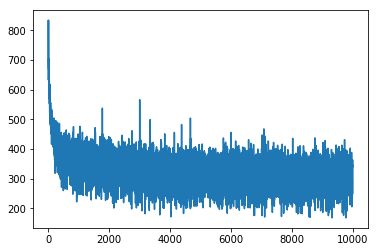

In [2]:
# Sina's training: Plot losses with 4000 epochs
plt.plot(all_losses)

In [14]:
#hidden = model.init_hidden()

for n in range(100):
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]      # torch.max(...)[1] gets the character in terms of its index, so

    for j in range(input_.size(0)):
        output, hidden = model(input_[j], hidden)
        
        
out_int=torch.max(output.view(1, -1), 1)[1][0]

for i in range(50):
    output_full=''
    for j in range(input_.size(0)):
        output, hidden = model(out_int, hidden)
        out_int = torch.max(output.view(1, -1), 1)[1][0]
        
        output_full=output_full+character_vec[int(out_int)]
    print(output_full)

S

What he shall the strace so the straction the straction,
And the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he shall 
the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he sh
all the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As h
e shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction

As he shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the straction
As he shall the strace so the straction the straction the st